In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [2]:
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt

In [3]:
import os.path as osp
import pickle

In [4]:
# from beetl.task_datasets import BeetlSleepTutorial, BeetlSleepSource, BeetlSleepLeaderboard, BeetlMILeaderboard
# ds = BeetlSleepSource()
# path = ds.download()
# print(path)
# X, y, info = ds.get_data()

In [5]:
# BeetlSleepLeaderboard().download()

In [6]:
from beetl.task_datasets import BeetlSleepSource
dataset = BeetlSleepSource()
X_train, y_train, info = dataset.get_data(subjects=range(34))
X_test, y_test, _ = dataset.get_data(subjects=range(35, 39))


In [7]:
SEED=997
BATCH_SIZE=128
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

(77452, 2, 3000)
[[    0 19333]
 [    1  7070]
 [    2 31776]
 [    3  4492]
 [    4  2413]
 [    5 12368]]


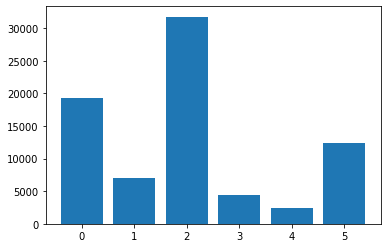

In [8]:
print(X_train.shape)
(unique, counts) = np.unique(np.asarray(y_train), return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
plt.bar(unique, counts)
plt.show()

# Load Dataset

In [10]:
from torch.utils.data import DataLoader, Dataset

class EEG_data(Dataset):
    def __init__(self, train_data, train_label, mode='train'):
        mean = np.mean(train_data, axis=2, keepdims=True)
        std = np.std(train_data, axis=2, keepdims=True)
        self.X = (train_data - mean) / std
        self.X = np.transpose(self.X, (0, 2, 1))
        self.X = np.expand_dims(self.X, axis=1)
        self.y = train_label
        self.mode = mode
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        shape = self.X[0].shape
        noise = np.random.normal(0, 0.04, 6000).reshape(shape)
        if self.y is not None:
            return torch.tensor(self.X[idx] + noise, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)
        else:
            return torch.tensor(self.X[idx], dtype=torch.float32)

In [11]:
from pytorch_metric_learning import samplers

In [12]:
X_train.shape

(77452, 2, 3000)

In [13]:
train_dataset = EEG_data(X_train, y_train)
test_dataset = EEG_data(X_test, y_test, mode='test')
print(train_dataset.X.shape) # should be length, 1, 3000, 2

(77452, 1, 3000, 2)


(array([   8.,    9.,   56.,  332.,  855., 1022.,  542.,  154.,   17.,
           5.]),
 array([-4.60794718, -3.72689206, -2.84583694, -1.96478182, -1.08372669,
        -0.20267157,  0.67838355,  1.55943867,  2.44049379,  3.32154891,
         4.20260403]),
 <BarContainer object of 10 artists>)

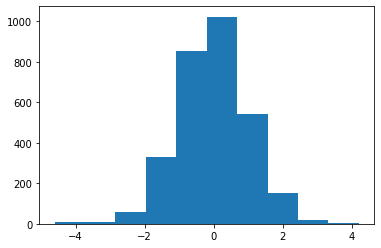

In [14]:
plt.hist(train_dataset.X[0][0][:, 0])

In [15]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, sampler=samplers.MPerClassSampler(labels=y_train, m=BATCH_SIZE // 6, length_before_new_iter=16000), batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [16]:
train_dataset[1], train_dataset[1][0].shape

((tensor([[[ 0.4317, -0.4486],
           [ 2.9892,  0.3648],
           [ 0.4987, -0.5602],
           ...,
           [-0.1246, -0.0963],
           [-0.3119,  0.0652],
           [-0.5738, -0.1668]]]),
  tensor(0)),
 torch.Size([1, 3000, 2]))

# LSTM NET

In [17]:
import torch.nn as nn
import torch.nn.functional as F
    
class LSTMNet(nn.Module):
    def __init__(self, n_classes):
        super(LSTMNet, self).__init__()
        self.drop1 = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)
        self.n_classes = n_classes

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=[30, 2], stride=1)
        self.bn1 = nn.BatchNorm1d(16)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=30, stride=1)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=30, stride=1)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.pool = nn.MaxPool1d(4)

        self.lstm = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)

        torch.nn.init.kaiming_normal_(self.conv1.weight)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        torch.nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        output = self.bn1(self.pool(F.relu(self.conv1(x)).reshape(x.shape[0], self.conv1.out_channels, -1)))
        output = self.bn2(self.pool(F.relu(self.conv2(output))))
        output = self.bn3(self.pool(F.relu(self.conv3(output))))
        # output's shape is batch, 64, 37
        
        _, (outputs, _) = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
#         output = torch.mean(outputs, 1) # batch, hidden_size
        output = torch.squeeze(outputs)
        output = F.relu(self.fc(self.drop1(output)))
#         scores = F.softmax(output, dim=-1)
        return output


In [18]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses as loss_fns

model = LSTMNet(n_classes=len(frequencies))
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
n_epochs = 20
llos = []
train_acc = []
lacc = []

In [ ]:
from tqdm.notebook import tqdm

for epoch in range(n_epochs):  # loop over the dataset multiple times
    model.train()
    print(f'Epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}')
    running_loss = 0.0
    total_loss = 0
    train_total = 0
    train_correct = 0
    with tqdm(train_loader) as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted_labels = torch.argmax(outputs, axis=1)
            train_correct += torch.sum(labels == predicted_labels).item()
            train_total += len(predicted_labels)

            # print statistics
            total_loss += loss.item() * len(labels)
            pbar.set_postfix(loss=loss.item(), accuracy=(train_correct / train_total))
    mean_loss = total_loss / train_total
    llos.append(mean_loss)
    
    train_acc.append(train_correct / train_total)

    val_correct = 0
    val_total = 0
    val_loss = 0
    model.eval()
    for _, (inputs, labels) in enumerate(test_loader):
        with torch.no_grad():
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            predicted_labels = torch.argmax(outputs, axis=1)
            val_total += len(labels)
            val_correct += torch.sum(labels == predicted_labels).item()
            
            val_loss += loss_fn(outputs, labels) * len(labels)
    scheduler.step(val_loss / val_total)
    
    acc = val_correct / val_total
    lacc.append(acc)
print('Finished Training')

Epoch: 0, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 1, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 2, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 3, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 4, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 5, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 6, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 7, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 8, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 9, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 10, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 11, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 12, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 13, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 14, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 15, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 16, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 17, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 18, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 19, LR: 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
plt.plot(lacc, label='Val Acc')
plt.plot(train_acc, label='Train Acc')
plt.plot(llos, label='Train loss')
plt.legend()
print(len(lacc))

In [79]:
torch.save(model, '../models/3-cnn-lstm-classification.pth')

acc: 81.528128%
[[3600  114   10   16    0   48]
 [  65  335  141    4    0  133]
 [   5  259 2688  214    2  110]
 [   1    2   48  517   95    0]
 [   0    0    1  257  386    0]
 [  46  302  107    0    0 1213]]
Normalized confusion matrix


<AxesSubplot:title={'center':'Validation confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

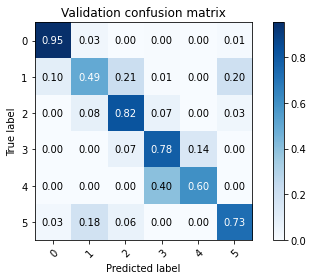

In [44]:
from util.preproc import plot_confusion_matrix

correct_count = 0
total = 0
predicted_labels = []
for idx, data in enumerate(test_loader):
    xx, yy = data
    total += len(yy)
    # cuda
    if torch.cuda.is_available():
        xx = xx.cuda()
    with torch.no_grad():
        model.eval()
        pred = model(xx)
        pred = np.argmax(pred.cpu().detach().numpy(), axis=1)
        predicted_labels.append(pred)
        correct_count += np.sum(pred == yy.detach().numpy())
print('acc: {:1f}%'.format(100 * correct_count / total))

predicted_labels = np.concatenate(predicted_labels)
plot_confusion_matrix(test_dataset.y, predicted_labels, classes=['0', '1', '2', '3', '4', '5'],
                                      normalize=True, title='Validation confusion matrix')

# Leaderboard data

In [23]:
from beetl.task_datasets import BeetlSleepLeaderboard
X_sleep_target, y_sleep_target, _, _ = BeetlSleepLeaderboard().get_data(subjects=range(0, 6))

In [24]:
transfer_dataset = EEG_data(X_sleep_target, y_sleep_target)
transfer_loader = torch.utils.data.DataLoader(dataset=transfer_dataset, batch_size=128)

acc: 70.463671%
15442 15442
[[5077  665   48   23    1  196]
 [ 196 1023  296   19    4  134]
 [  18  936 3287  561   36  197]
 [   0    5  117  512   43   27]
 [   0    0    4  292  118    0]
 [  40  609   93    1    0  864]]
Normalized confusion matrix


<AxesSubplot:title={'center':'Validation confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

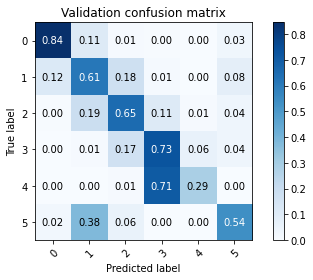

In [45]:
from util.preproc import plot_confusion_matrix

correct_count = 0
total = 0
predicted_labels = []
for idx, data in enumerate(transfer_loader):
    xx, yy = data
    total += len(yy)
    # cuda
    if torch.cuda.is_available():
        xx = xx.cuda()
    with torch.no_grad():
        model.eval()
        pred = model(xx)
        pred = np.argmax(pred.cpu().detach().numpy(), axis=1)
        predicted_labels.append(pred)
        correct_count += np.sum(pred == yy.detach().numpy())
print('acc: {:1f}%'.format(100 * correct_count / total))

predicted_labels = np.concatenate(predicted_labels)
print(len(transfer_dataset.y), len(predicted_labels))
plot_confusion_matrix(transfer_dataset.y, predicted_labels, classes=['0', '1', '2', '3', '4', '5'],
                                      normalize=True, title='Validation confusion matrix')

In [109]:
from beetl.task_datasets import BeetlSleepLeaderboard
_, _, X_sleep_test, _ = BeetlSleepLeaderboard().get_data(subjects=range(6, 18))

In [132]:
submission_dataset = EEG_data(X_sleep_test, None)
submission_loader = torch.utils.data.DataLoader(dataset=submission_dataset, batch_size=128)

In [133]:
predicted_labels = []
for idx, inputs in enumerate(submission_loader):
    inputs = inputs.to(device)
    with torch.no_grad():
        model.eval()
        outputs = model(inputs)
        pred = np.argmax(outputs.cpu().detach().numpy(), axis=1)
        predicted_labels.extend(pred)
predicted_labels = predicted_labels

In [88]:
print(predicted_labels[:20])
#label from 0 - 5
np.savetxt("answer.txt",predicted_labels,delimiter=',',fmt="%d")

[0, 1, 0, 2, 1, 2, 1, 1, 2, 2, 2, 0, 0, 5, 1, 5, 0, 2, 2, 1]


In [89]:
print(len(predicted_labels))

25748
